# Model Preparation: Factors that affect life expectancy

Data cleaning/exploration, feature engineering

(Data set: https://www.kaggle.com/kumarajarshi/life-expectancy-who/home)

Find out which factors increase the expected life in the countries and which factors decrease it.

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib.mlab import PCA as mlabPCA

from scipy.stats import zscore
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

## 1). Data Cleaning

### Missing Data

In [3]:
lifeexpectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
# rename columns:
lifeexpectancy_df.columns = lifeexpectancy_df.columns.str.strip().str.lower().str.replace(' ','_')

In [5]:
# review variables:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

In [6]:
# get percentage of missing values:
lifeexpectancy_df.isnull().sum() * 100 / lifeexpectancy_df.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                 1.157250
under-five_deaths                   0.000000
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness__1-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [7]:
# review unique values to get a sense of possible issues with data:
# for column_name in lifeexpectancy_df.columns:
#     print("Unique values in column {} are: {}".format(column_name, lifeexpectancy_df[column_name].unique()))

In [8]:
# fix a typo:
lifeexpectancy_df['country'] = lifeexpectancy_df['country'].replace('Viet Nam', 'Vietnam')

In [9]:
# Check the accuracy of status:
print(lifeexpectancy_df.loc[lifeexpectancy_df['status'] == 'Developed', 'country'].unique())
print(lifeexpectancy_df.loc[lifeexpectancy_df['status'] == 'Developing', 'country'].unique())

['Australia' 'Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia'
 'Denmark' 'Slovakia' 'Germany' 'Hungary' 'Iceland' 'Ireland' 'Italy'
 'Japan' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta' 'Netherlands'
 'New Zealand' 'Norway' 'Poland' 'Portugal' 'Romania' 'Singapore'
 'Slovenia' 'Spain' 'Sweden' 'Switzerland'
 'United Kingdom of Great Britain and Northern Ireland'
 'United States of America']
['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Benin' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Cuba'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Djibouti' 'Dominica'
 'Dominican R

In [10]:
# fix countries classification:
# (https://www.un.org/en/development/desa/policy/wesp/wesp_current/2014wesp_country_classification.pdf
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Canada', 'status'] = 'Developed'
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Estonia', 'status'] = 'Developed'
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Finland', 'status'] = 'Developed'
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'France', 'status'] = 'Developed'
lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Greece', 'status'] = 'Developed'

lifeexpectancy_df.loc[lifeexpectancy_df['country'] == 'Singapore', 'status'] = 'Developing'

When reviewing unique values, we notice some strange values that look like data entry/processing errors. Online research confirms the variables should be dropped:

- infant_deaths data is incorrect:
https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?end=2015&name_desc=false;
- percentage_expenditure is supposed to be "Expenditure on health as a percentage of Gross Domestic Product per capita", but the values range from 0 to 19479.91161 (with U.S., for example, allocating 0%). It's unclear where are the totals and where are percentages;
- general government expenditure on health as a percentage of total government expenditure is incorrect: http://data.un.org/Data.aspx?d=WHO&f=MEASURE_CODE%3AWHS7_113;
- HIV/AIDs death rates among  children are imprecise: https://apps.who.int/gho/data/view.main.ghe2002015-CH2;
- schooling values are incorrect: https://en.wikipedia.org/wiki/Education_Index;
- bmi values are incorrect: we have values such as 65.4, 66.4 -- it's unclear what values there are actual numbers and what values are percentages.

In addition, dropping the following variables for now (the values can be fixed by applying a function to multiply by 10/more zeroes if other numbers per country contain a certain amount of digits):

- gdp and population numbers are incorrect, looks like zeroes are missing
- polio coverage missing zeros - should be two digits

Also note:
- under-five deaths are in "thousands," not in "per 1000 population": http://apps.who.int/gho/data/node.country.country-DZA?lang=en;
- for measles, the data set description states that the data are "number of reported cases per 1000 population" - but online search confirms the numbers are total reported cases. 

In [11]:
# drop variables with incorrect data:
lifeexpectancy_df = lifeexpectancy_df.drop(['infant_deaths', 
                                           'percentage_expenditure',
                                           'total_expenditure',
                                           'hiv/aids',
                                           'schooling',
                                           'bmi'], axis=1)
lifeexpectancy_df = lifeexpectancy_df.drop(['gdp', 
                                           'population',
                                           'polio'], axis=1)

In [12]:
# make sure there are no empty string values:
lifeexpectancy_df = lifeexpectancy_df.replace("", np.nan)

<b>The following variables have missing values largerly for one year for different countries:</b>
- life_expectancy,
- adult_mortality,
- alcohol.

We'll use interpolation to impute data.

In [13]:
countries = lifeexpectancy_df['country'].unique()
status = lifeexpectancy_df['status'].unique()

In [14]:
# use interpolation to impute data:
to_fill = ['life_expectancy', 'adult_mortality', 'alcohol']        
            
for col in to_fill:
    for country in countries:
        lifeexpectancy_df.loc[:, col].interpolate(inplace=True)

<b>The following variables have missing values over multiple years for different countries:</b>

- hepatitis_b,
- income_composition_of_resources,
- diphtheria,
- thinness__1-19_years,
- thinness_5-9_years.

We'll use average values per country to impute data.

In [15]:
# use mean to impute data:
to_fill2 = ['hepatitis_b', 'income_composition_of_resources',
            'diphtheria', 'thinness__1-19_years', 'thinness_5-9_years']

for i in to_fill2:
    for country in countries:
        lifeexpectancy_df.loc[:, i].fillna(lifeexpectancy_df.loc[:,i]
                                       .mean(), inplace=True)

In [16]:
# verify there are no missing values:
lifeexpectancy_df.isnull().sum() * 100 / lifeexpectancy_df.isnull().count()

country                            0.0
year                               0.0
status                             0.0
life_expectancy                    0.0
adult_mortality                    0.0
alcohol                            0.0
hepatitis_b                        0.0
measles                            0.0
under-five_deaths                  0.0
diphtheria                         0.0
thinness__1-19_years               0.0
thinness_5-9_years                 0.0
income_composition_of_resources    0.0
dtype: float64

### Outliers

We'll review variables by category and use winsorization to decrease the number of outliers.

#### Life Expectancy

Text(0.5, 1.0, 'Box plot of life expectancy (whis=1.5)')

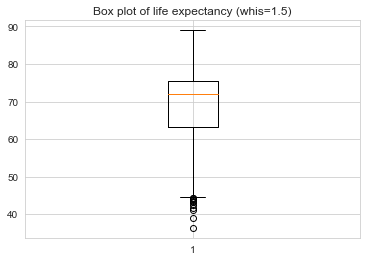

In [17]:
# plot life expectancy:
plt.boxplot(lifeexpectancy_df['life_expectancy'], whis=1.5)
plt.title('Box plot of life expectancy (whis=1.5)')

In [18]:
# winsorize:
life_expectancy2 = winsorize(lifeexpectancy_df['life_expectancy'], (0.10, 0))

Text(0.5, 1.0, 'Box plot of life_expectancy2 (whis=1.5)')

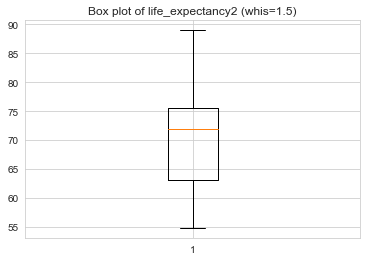

In [19]:
plt.boxplot(life_expectancy2, whis=1.5)
plt.title("Box plot of life_expectancy2 (whis=1.5)")

#### Immunization-related Factors

Text(0.5, 1.0, 'Box plot of measles (whis=20)')

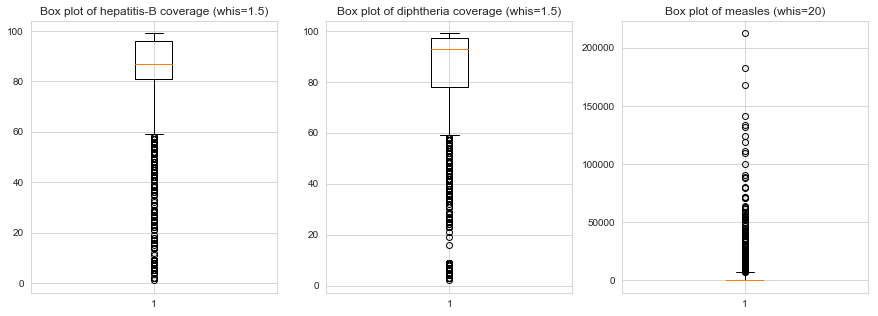

In [20]:
# Immunization-related factors
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(lifeexpectancy_df['hepatitis_b'], whis=1.5)
plt.title('Box plot of hepatitis-B coverage (whis=1.5)')

plt.subplot(1,3,2)
plt.boxplot(lifeexpectancy_df['diphtheria'], whis=1.)
plt.title('Box plot of diphtheria coverage (whis=1.5)')

plt.subplot(1,3,3)
plt.boxplot(lifeexpectancy_df['measles'], whis=20)
plt.title('Box plot of measles (whis=20)')

In [21]:
# winsorize the variables:
hepatitis_b2 = winsorize(lifeexpectancy_df['hepatitis_b'], (0.15, 0))
diphtheria2 = winsorize(lifeexpectancy_df['diphtheria'], (0.15, 0))
measles2 = winsorize(lifeexpectancy_df['measles'], (0, 0.15))

Text(0.5, 1.0, 'Box plot of measles (whis=1.5)')

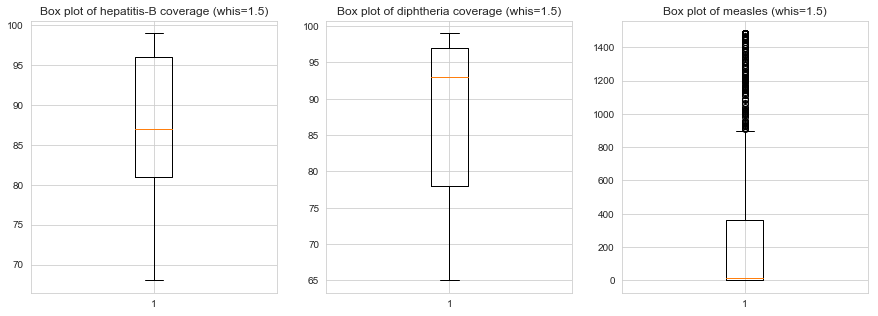

In [22]:
# Immunization-related factors
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(hepatitis_b2, whis=1.5)
plt.title('Box plot of hepatitis-B coverage (whis=1.5)')

plt.subplot(1,3,2)
plt.boxplot(diphtheria2, whis=1.5)
plt.title('Box plot of diphtheria coverage (whis=1.5)')

plt.subplot(1,3,3)
plt.boxplot(measles2, whis=1.5)
plt.title('Box plot of measles (whis=1.5)')

Measles still has a lot of outliers that could stem from issues with data entry; we'll exclude it from further data analysis.

#### Mortality Factors

Text(0.5, 1.0, 'Box plot of under-five_deaths (whis=5)')

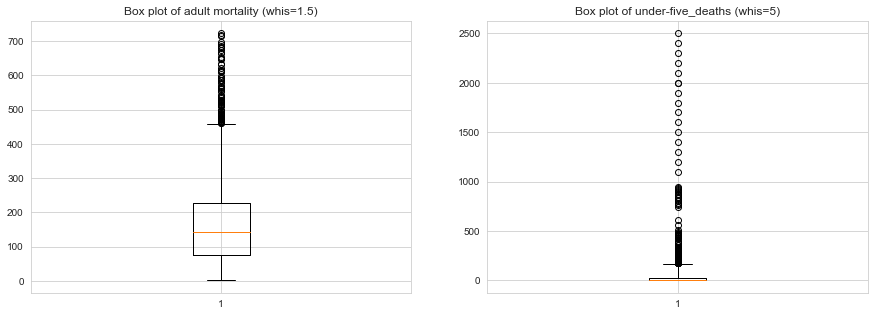

In [23]:
# Mortality factors
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(lifeexpectancy_df['adult_mortality'], whis=1.5)
plt.title("Box plot of adult mortality (whis=1.5)")

plt.subplot(1,2,2)
plt.boxplot(lifeexpectancy_df['under-five_deaths'], whis=5)
plt.title("Box plot of under-five_deaths (whis=5)")

In [24]:
# winsorize the variables:
adult_mortality2 = winsorize(lifeexpectancy_df['adult_mortality'], (0, 0.05))
under_five_deaths2 = winsorize(lifeexpectancy_df['under-five_deaths'], (0, 0.05))

Text(0.5, 1.0, 'Box plot of under-five_deaths (whis=5)')

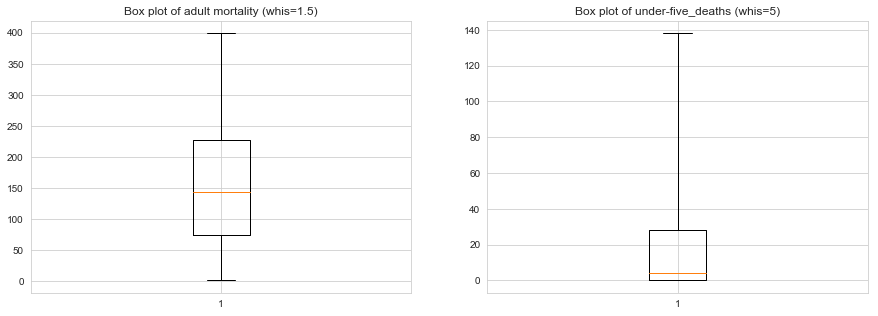

In [25]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(adult_mortality2, whis=1.5)
plt.title('Box plot of adult mortality (whis=1.5)')

plt.subplot(1,2,2)
plt.boxplot(under_five_deaths2, whis=5)
plt.title('Box plot of under-five_deaths (whis=5)')

#### Economic Factors

Text(0.5, 1.0, 'Box plot of ncome_composition_of_resources (whis=1.5)')

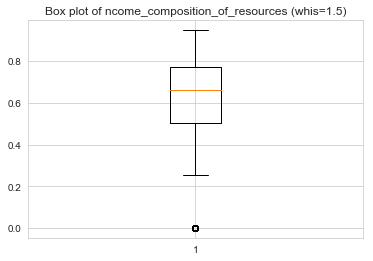

In [26]:
# Economic factors
plt.boxplot(lifeexpectancy_df['income_composition_of_resources'], whis=1.5)
plt.title('Box plot of ncome_composition_of_resources (whis=1.5)')

In [27]:
income_composition_of_resources2 = winsorize(
    lifeexpectancy_df['income_composition_of_resources'], (0.1, 0))

Text(0.5, 1.0, 'Box plot of income_composition_of_resources (whis=1.5)')

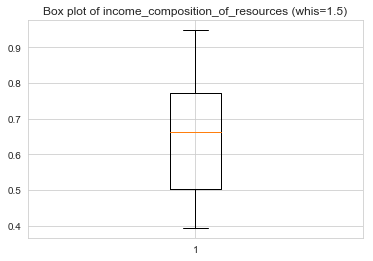

In [28]:
plt.boxplot(income_composition_of_resources2, whis=1.5)
plt.title('Box plot of income_composition_of_resources (whis=1.5)')

#### Social Factors

Text(0.5, 1.0, 'Box plot of thinness_5-9_years (whis=1.5)')

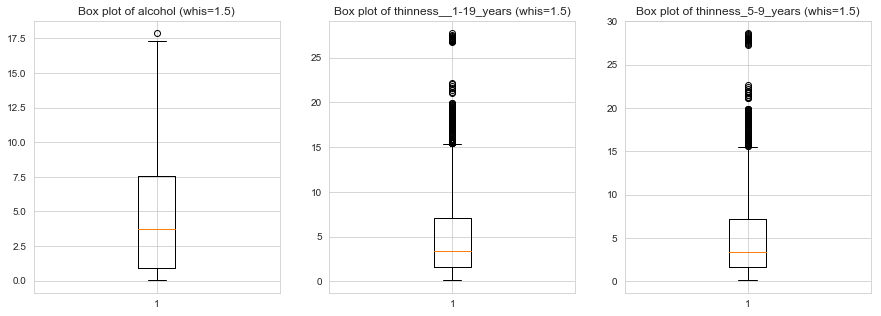

In [29]:
# Social factors
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(lifeexpectancy_df['alcohol'], whis=1.5)
plt.title('Box plot of alcohol (whis=1.5)')

plt.subplot(1,3,2)
plt.boxplot(lifeexpectancy_df['thinness__1-19_years'], whis=1.5)
plt.title('Box plot of thinness__1-19_years (whis=1.5)')

plt.subplot(1,3,3)
plt.boxplot(lifeexpectancy_df['thinness_5-9_years'], whis=1.5)
plt.title('Box plot of thinness_5-9_years (whis=1.5)')

In [30]:
# Winsorize the variables:
alcohol2 = winsorize(lifeexpectancy_df['alcohol'], (0, 0.01))
thinness__1_19_years2 = winsorize(lifeexpectancy_df['thinness__1-19_years'], (0, 0.05))
thinness_5_9_years2 = winsorize(lifeexpectancy_df['thinness_5-9_years'], (0, 0.05))

Text(0.5, 1.0, 'Box plot of thinness_5-9_years (whis=1.5)')

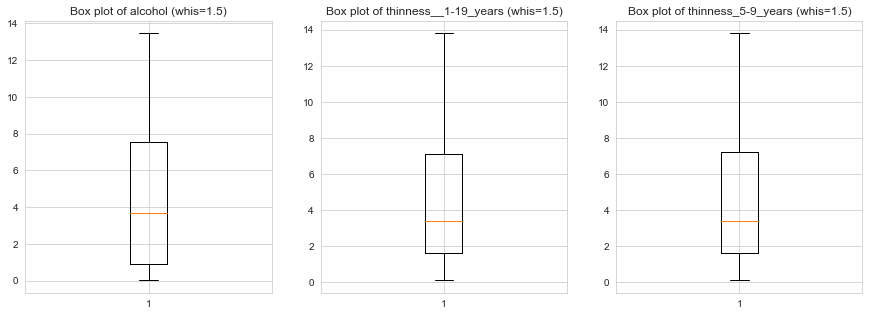

In [31]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.boxplot(alcohol2, whis=1.5)
plt.title('Box plot of alcohol (whis=1.5)')

plt.subplot(1,3,2)
plt.boxplot(thinness__1_19_years2, whis=1.5)
plt.title('Box plot of thinness__1-19_years (whis=1.5)')

plt.subplot(1,3,3)
plt.boxplot(thinness_5_9_years2, whis=1.5)
plt.title('Box plot of thinness_5-9_years (whis=1.5)')

In [32]:
# cretae a new dataframe with winsorized values: 
lifeexpectancy_df2 = lifeexpectancy_df.copy()

lifeexpectancy_df2 = lifeexpectancy_df2.drop(['measles'], axis=1)

lifeexpectancy_df2['life_expectancy'] = life_expectancy2
lifeexpectancy_df2['hepatitis_b'] = hepatitis_b2
lifeexpectancy_df2['diphtheria'] = diphtheria2
lifeexpectancy_df2['adult_mortality'] = adult_mortality2
lifeexpectancy_df2['under-five_deaths'] = under_five_deaths2
lifeexpectancy_df2['income_composition_of_resources'] = income_composition_of_resources2
lifeexpectancy_df2['alcohol'] = alcohol2
lifeexpectancy_df2['thinness__1-19_years'] = thinness__1_19_years2
lifeexpectancy_df2['thinness_5-9_years'] = thinness_5_9_years2

# 2). Data Exploration

### Univariate Analysis

In [33]:
lifeexpectancy_df2.describe()

,year,life_expectancy,adult_mortality,alcohol,hepatitis_b,under-five_deaths,diphtheria,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.666440,159.665248,4.535512,85.844478,23.484683,87.049407,4.641406,4.648363,0.647884
std,4.613841,8.607764,110.245123,3.960835,10.556754,38.567699,12.066384,3.766525,3.778567,0.157922
min,2000.000000,54.800000,1.000000,0.010000,68.000000,0.000000,65.000000,0.100000,0.100000,0.394000
25%,2004.000000,63.100000,74.000000,0.902500,80.940461,0.000000,78.000000,1.600000,1.600000,0.504250
50%,2008.000000,72.000000,144.000000,3.697500,87.000000,4.000000,93.000000,3.400000,3.400000,0.662000
75%,2012.000000,75.600000,228.000000,7.550000,96.000000,28.000000,97.000000,7.100000,7.200000,0.772000
max,2015.000000,89.000000,399.000000,13.450000,99.000000,138.000000,99.000000,13.800000,13.800000,0.948000


In [34]:
# compare means to variables in the original dataframe to see the effects of winsorization:
lifeexpectancy_df.describe()

,year,life_expectancy,adult_mortality,alcohol,hepatitis_b,measles,under-five_deaths,diphtheria,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,4.548919,80.940461,2419.592240,42.035739,82.324084,4.839704,4.870317,0.627551
std,4.613841,9.510819,124.226596,3.994854,22.586855,11467.272489,160.445548,23.640073,4.394535,4.482708,0.204820
min,2000.000000,36.300000,1.000000,0.010000,1.000000,0.000000,0.000000,2.000000,0.100000,0.100000,0.000000
25%,2004.000000,63.100000,74.000000,0.902500,80.940461,0.000000,0.000000,78.000000,1.600000,1.600000,0.504250
50%,2008.000000,72.000000,144.000000,3.697500,87.000000,17.000000,4.000000,93.000000,3.400000,3.400000,0.662000
75%,2012.000000,75.600000,228.000000,7.550000,96.000000,360.250000,28.000000,97.000000,7.100000,7.200000,0.772000
max,2015.000000,89.000000,723.000000,17.870000,99.000000,212183.000000,2500.000000,99.000000,27.700000,28.600000,0.948000


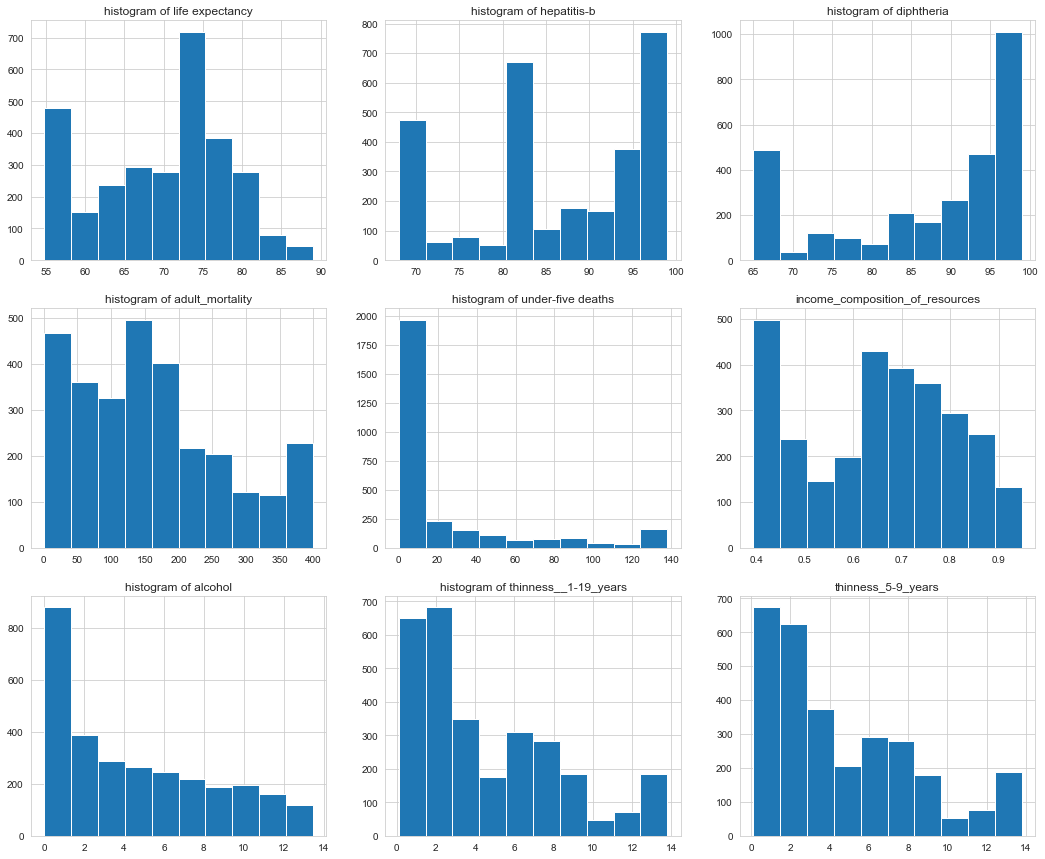

In [35]:
# review distribution of variables:
plt.figure(figsize=(18,15))

plt.subplot(3, 3, 1)
plt.hist(lifeexpectancy_df2['life_expectancy'])
plt.title('histogram of life expectancy')

plt.subplot(3, 3, 2)
plt.hist(lifeexpectancy_df2['hepatitis_b'])
plt.title('histogram of hepatitis-b')

plt.subplot(3, 3, 3)
plt.hist(lifeexpectancy_df2['diphtheria'])
plt.title('histogram of diphtheria')

plt.subplot(3, 3, 4)
plt.hist(lifeexpectancy_df2['adult_mortality'])
plt.title('histogram of adult_mortality')

plt.subplot(3, 3, 5)
plt.hist(lifeexpectancy_df2['under-five_deaths'])
plt.title('histogram of under-five deaths')

plt.subplot(3, 3, 6)
plt.hist(lifeexpectancy_df2['income_composition_of_resources'])
plt.title('income_composition_of_resources')

plt.subplot(3, 3, 7)
plt.hist(lifeexpectancy_df2['alcohol'])
plt.title('histogram of alcohol')

plt.subplot(3, 3, 8)
plt.hist(lifeexpectancy_df2['thinness__1-19_years'])
plt.title('histogram of thinness__1-19_years')

plt.subplot(3, 3, 9)
plt.hist(lifeexpectancy_df2['thinness_5-9_years'])
plt.title('thinness_5-9_years')

plt.show()

Life expectancy distribution resebles normal distribution, but, overall, variables are not normally distributed.

In [36]:
lifeexpectancy_df2.describe(include='O')

,country,status
count,2938,2938
unique,193,2
top,Panama,Developing
freq,16,2362


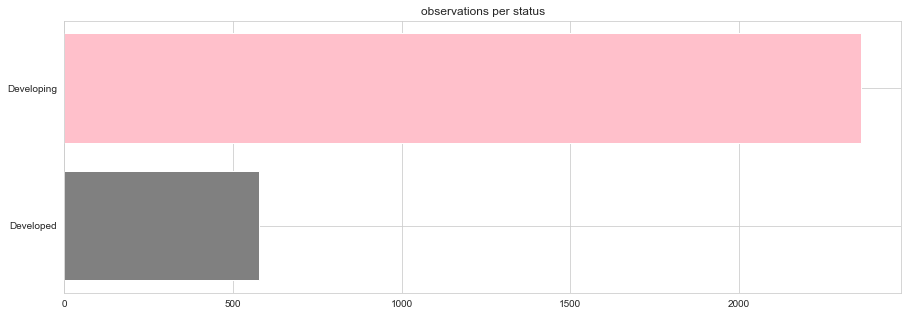

In [37]:
# bar chart of status
plt.figure(figsize=(15,5))
plt.barh(lifeexpectancy_df2.groupby('status')['status'].count().index, 
        lifeexpectancy_df2.groupby('status')['status'].count(), 
        color=['grey', 'pink'])
plt.title('observations per status')

plt.show()

There are 4 times more observations for developing countries.

### Multivariate Analysis

Life expectancy is our target variable.

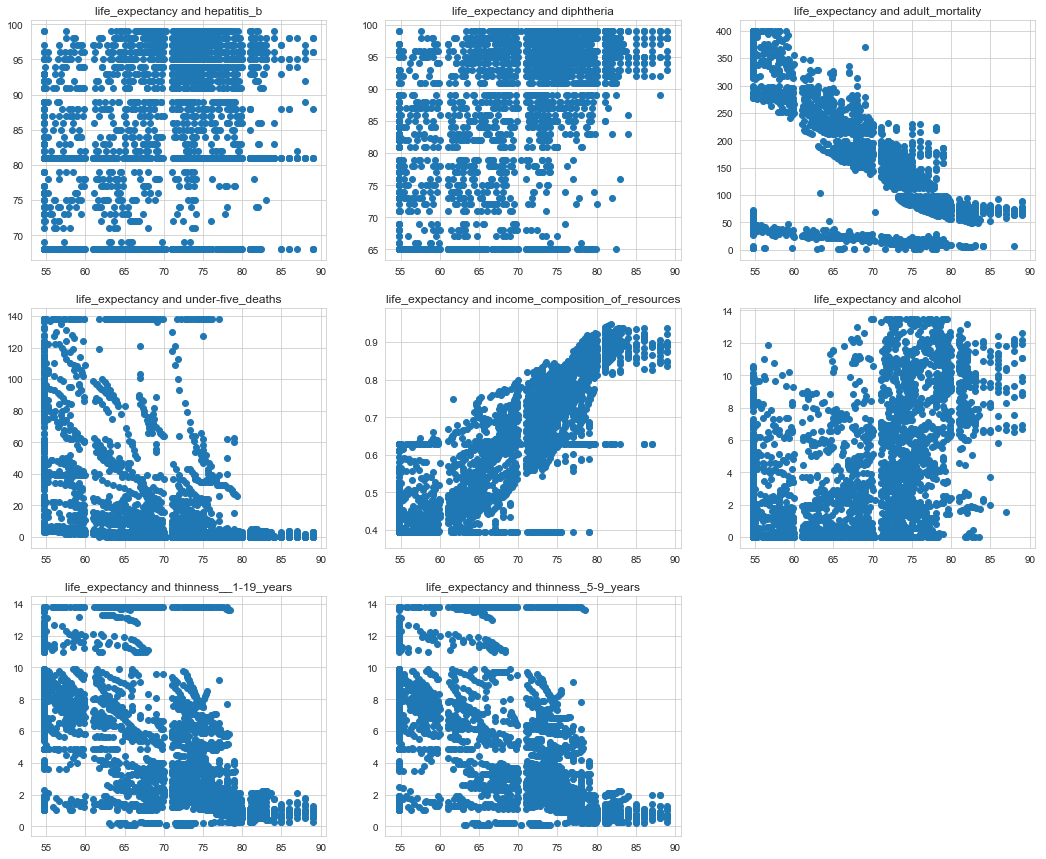

In [38]:
# Review variables with respect to life expectancy:
plt.figure(figsize=(18,15))

plt.subplot(3,3,1)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['hepatitis_b'])
plt.title('life_expectancy and hepatitis_b')

plt.subplot(3,3,2)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['diphtheria'])
plt.title('life_expectancy and diphtheria')

plt.subplot(3,3,3)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['adult_mortality'])
plt.title('life_expectancy and adult_mortality')

plt.subplot(3,3,4)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['under-five_deaths'])
plt.title('life_expectancy and under-five_deaths')

plt.subplot(3,3,5)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['income_composition_of_resources'])
plt.title('life_expectancy and income_composition_of_resources')

plt.subplot(3,3,6)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['alcohol'])
plt.title('life_expectancy and alcohol')

plt.subplot(3,3,7)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['thinness__1-19_years'])
plt.title('life_expectancy and thinness__1-19_years')

plt.subplot(3,3,8)
plt.scatter(lifeexpectancy_df2['life_expectancy'], lifeexpectancy_df2['thinness_5-9_years'])
plt.title('life_expectancy and thinness_5-9_years')

plt.show()

Looks like income composition of resources has the most correlation with life expectancy compared the other variables under review. 

In [39]:
# get correlation of variables:
life_exp_corr = lifeexpectancy_df2.corr()

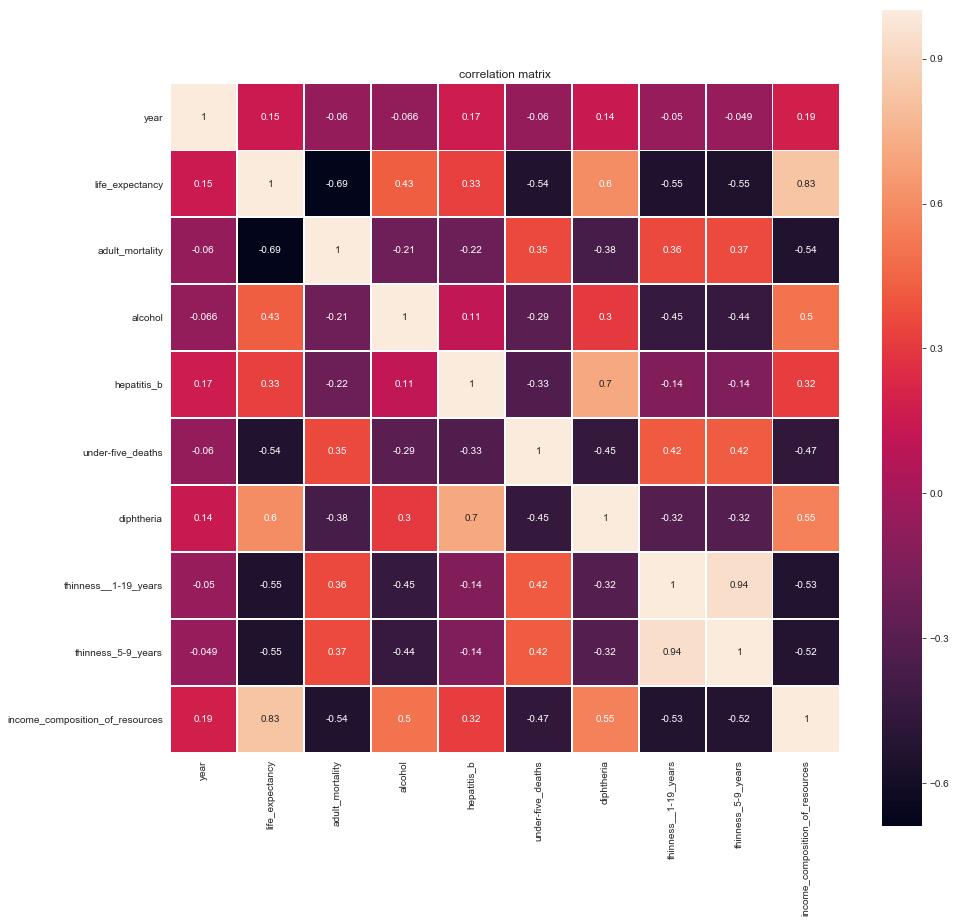

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(life_exp_corr, square=True, annot=True, linewidths=.5)
plt.title('correlation matrix')
plt.show()

<b>Life expectancy is:

- highly correlated with income composition of resources, as well as immunization (diphtheria);
- inversely correlated with thinness and mortality indicators.</b>

Given that we have more deeloping countries than developed countries and more observations for developing countries, we'll also review some statistics per status:

In [41]:
# review averages by status:
lifeexpectancy_df2.groupby('status').mean()

,year,life_expectancy,adult_mortality,alcohol,hepatitis_b,under-five_deaths,diphtheria,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources
status,,,,,,,,,,
Developed,2007.500000,79.267708,81.607639,9.758785,86.760990,1.772569,94.671875,1.251563,1.226042,0.834424
Developing,2007.523285,67.325064,178.700466,3.261759,85.620976,28.779424,85.190583,5.468057,5.482934,0.602394


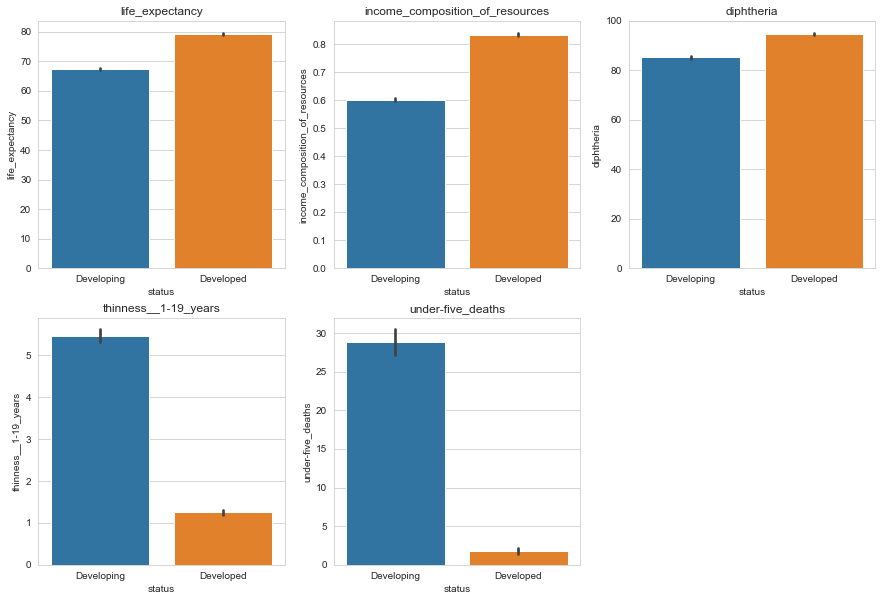

In [42]:
# review 
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.barplot(lifeexpectancy_df2['status'], lifeexpectancy_df2['life_expectancy'])
plt.title('life_expectancy')

plt.subplot(2,3,2)
sns.barplot(lifeexpectancy_df2['status'], lifeexpectancy_df2['income_composition_of_resources'])
plt.title('income_composition_of_resources')

plt.subplot(2,3,3)
sns.barplot(lifeexpectancy_df2['status'], lifeexpectancy_df2['diphtheria'])
plt.title('diphtheria')

plt.subplot(2,3,4)
sns.barplot(lifeexpectancy_df2['status'], lifeexpectancy_df2['thinness__1-19_years'])
plt.title('thinness__1-19_years')

plt.subplot(2,3,5)
sns.barplot(lifeexpectancy_df2['status'], lifeexpectancy_df2['under-five_deaths'])
plt.title('under-five_deaths')

plt.show()

In [43]:
# test if differences are statisticaly significant:
ttest_ind(lifeexpectancy_df2[lifeexpectancy_df2.status == 'Developing']
          [['life_expectancy', 'income_composition_of_resources', 'diphtheria', 'thinness__1-19_years', 'under-five_deaths']],
          lifeexpectancy_df2[lifeexpectancy_df2.status == 'Developed']
          [['life_expectancy', 'income_composition_of_resources', 'diphtheria', 'thinness__1-19_years', 'under-five_deaths']])

Ttest_indResult(statistic=array([-35.76866799, -38.92270391, -17.79432596,  26.88835385,
        15.68462713]), pvalue=array([6.75308608e-233, 1.36524385e-267, 2.37861236e-067, 1.48686391e-142,
       2.64650266e-053]))

Life expectancy, income composition of resources and diphtheria immunization are more widespread in developed countries, and thinness 1-19 years and under five mortality rates are higher in developing countries.

# 3). Feature Engineering

Given that life expectancy is highly correlated with income composition of resources, as well as immunization, and inversely correlated with thinness and mortality indicators, we can select a few variables that will be useful for modeling.

Target variable: life_expectancy.

The following variables are higly correlated, so we'll select just one of each:
- thinness 1-19 years and thinness 5-9 years are highly correlated;
- diphtheria and hepatitis_b immunization coverage are correlated.

We'll pick the following variables as our possible features:
- diphtheria (immunization),
- income composition of resources (economic),
- under-five deaths (mortality),
- thinness 1-19 years (social),

as well as:
- status.

For the modeling phase, we would:
- transform the variables into numeric variables,
- transform our data to be normally distributed,
- normalize and standartize variables.

In [44]:
features = lifeexpectancy_df2[['life_expectancy','diphtheria',
                               'under-five_deaths','income_composition_of_resources',
                               'thinness__1-19_years', 'status']]

In [45]:
features.head()

,life_expectancy,diphtheria,under-five_deaths,income_composition_of_resources,thinness__1-19_years,status
0,65.0,65.0,83,0.479,13.8,Developing
1,59.9,65.0,86,0.476,13.8,Developing
2,59.9,65.0,89,0.470,13.8,Developing
3,59.5,67.0,93,0.463,13.8,Developing
4,59.2,68.0,97,0.454,13.8,Developing


In [46]:
# transform categorical variable into numeric:
features = pd.concat([features, pd.get_dummies(features['status'])],
                              axis=1)
features = features.drop('status', axis=1)
features.columns = features.columns.str.lower()
features.head()

,life_expectancy,diphtheria,under-five_deaths,income_composition_of_resources,thinness__1-19_years,developed,developing
0,65.0,65.0,83,0.479,13.8,0,1
1,59.9,65.0,86,0.476,13.8,0,1
2,59.9,65.0,89,0.470,13.8,0,1
3,59.5,67.0,93,0.463,13.8,0,1
4,59.2,68.0,97,0.454,13.8,0,1


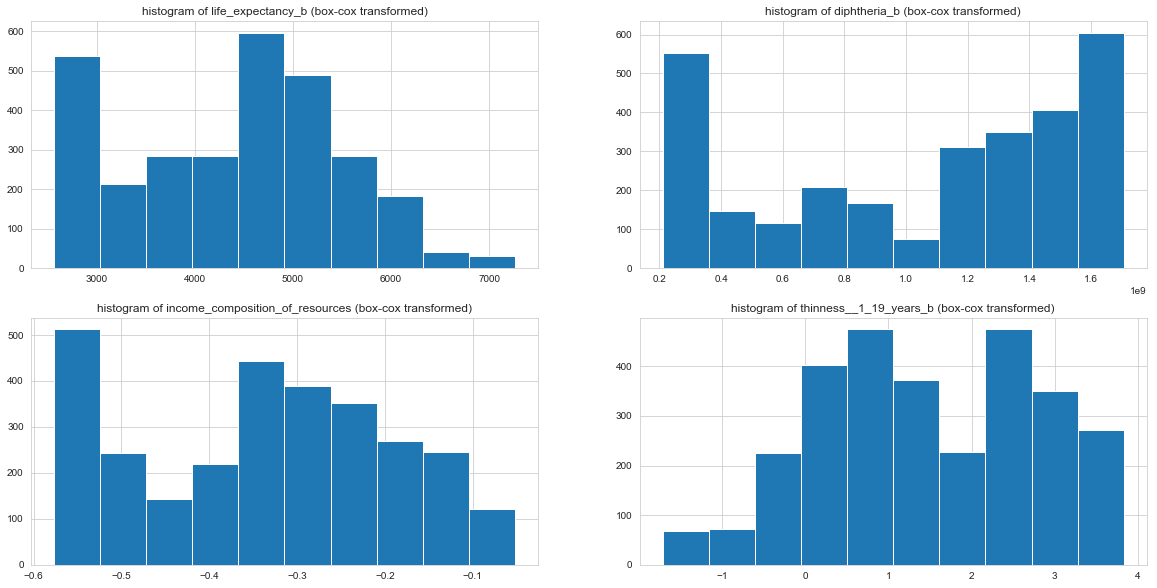

In [47]:
#transform variables to be normally distributed:
# transform using boxcox
life_expectancy_b,_=boxcox(features['life_expectancy'])
diphtheria_b,_=boxcox(features['diphtheria'])
income_composition_of_resources_b,_=boxcox(features['income_composition_of_resources'])
thinness__1_19_years_b,_=boxcox(features['thinness__1-19_years'])

plt.figure(figsize=(20,10))

# histograms of the box-cox transformed data
plt.subplot(2, 2, 1)
plt.hist(life_expectancy_b)
plt.title('histogram of life_expectancy_b (box-cox transformed)')

plt.subplot(2, 2, 2)
plt.hist(diphtheria_b)
plt.title('histogram of diphtheria_b (box-cox transformed)')

plt.subplot(2, 2, 3)
plt.hist(income_composition_of_resources_b)
plt.title('histogram of income_composition_of_resources (box-cox transformed)')

plt.subplot(2, 2, 4)
plt.hist(thinness__1_19_years_b)
plt.title('histogram of thinness__1_19_years_b (box-cox transformed)')

plt.show()

In [48]:
# test:
jb_stats = jarque_bera(life_expectancy_b)
norm_stats = normaltest(life_expectancy_b)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diphtheria_b)
norm_stats = normaltest(diphtheria_b)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(income_composition_of_resources_b)
norm_stats = normaltest(income_composition_of_resources_b)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(thinness__1_19_years_b)
norm_stats = normaltest(thinness__1_19_years_b)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 79.9683384195411 and p value is 0.0
Normality test statistics is 238.4026874001768 and p value is 1.704175022047886e-52
Jarque-Bera test statistics is 295.3755272600796 and p value is 0.0
Normality test statistics is 23578.00671273511 and p value is 0.0
Jarque-Bera test statistics is 148.0070093974717 and p value is 0.0
Normality test statistics is 1016.0538584329983 and p value is 2.3265263893655415e-221
Jarque-Bera test statistics is 79.5797426213899 and p value is 0.0
Normality test statistics is 241.32827524610596 and p value is 3.9466704745849576e-53


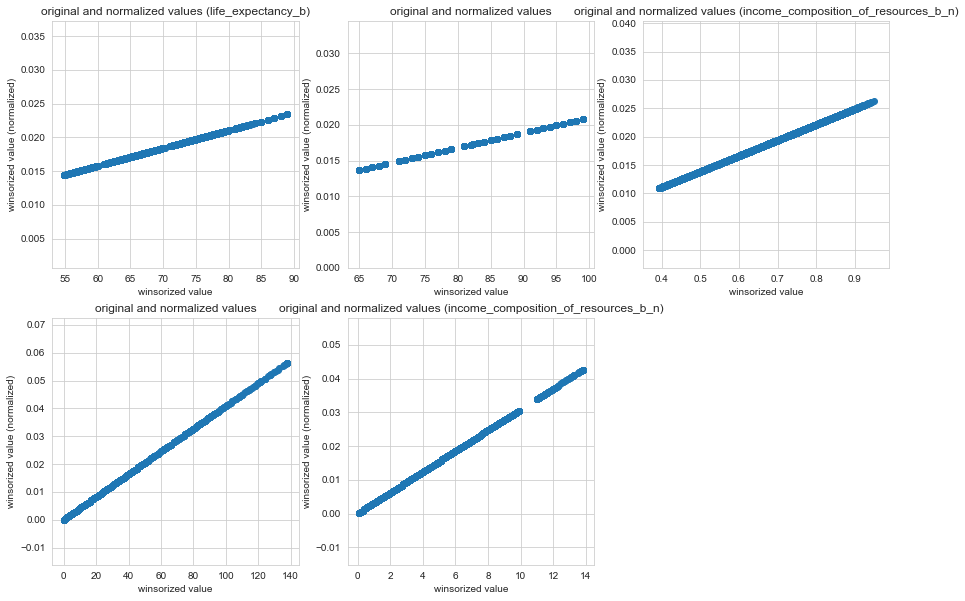

In [49]:
# normalize the winsorized variables
from sklearn.preprocessing import normalize
features['life_expectancy_b_n'] = normalize(np.array(features['life_expectancy']).reshape(1,-1)).reshape(-1,1)
features['diphtheria_b_n'] = normalize(np.array(features['diphtheria']).reshape(1,-1)).reshape(-1,1)
features['income_composition_of_resources_b_n'] = normalize(np.array(features['income_composition_of_resources']).reshape(1,-1)).reshape(-1,1)
features['under-five_deaths_n'] = normalize(np.array(features['under-five_deaths']).reshape(1,-1)).reshape(-1,1)
features['thinness__1-19_years_n'] = normalize(np.array(features['thinness__1-19_years']).reshape(1,-1)).reshape(-1,1)
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(features['life_expectancy'], features['life_expectancy_b_n'])
plt.title('original and normalized values (life_expectancy_b)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(2,3,2)
plt.scatter(features['diphtheria'], features['diphtheria_b_n'])
plt.title('original and normalized values')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(2,3,3)
plt.scatter(features['income_composition_of_resources'], features['income_composition_of_resources_b_n'])
plt.title('original and normalized values (income_composition_of_resources_b_n)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(2,3,4)
plt.scatter(features['under-five_deaths'], features['under-five_deaths_n'])
plt.title('original and normalized values')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(2,3,5)
plt.scatter(features['thinness__1-19_years'], features['thinness__1-19_years_n'])
plt.title('original and normalized values (income_composition_of_resources_b_n)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')
plt.show()

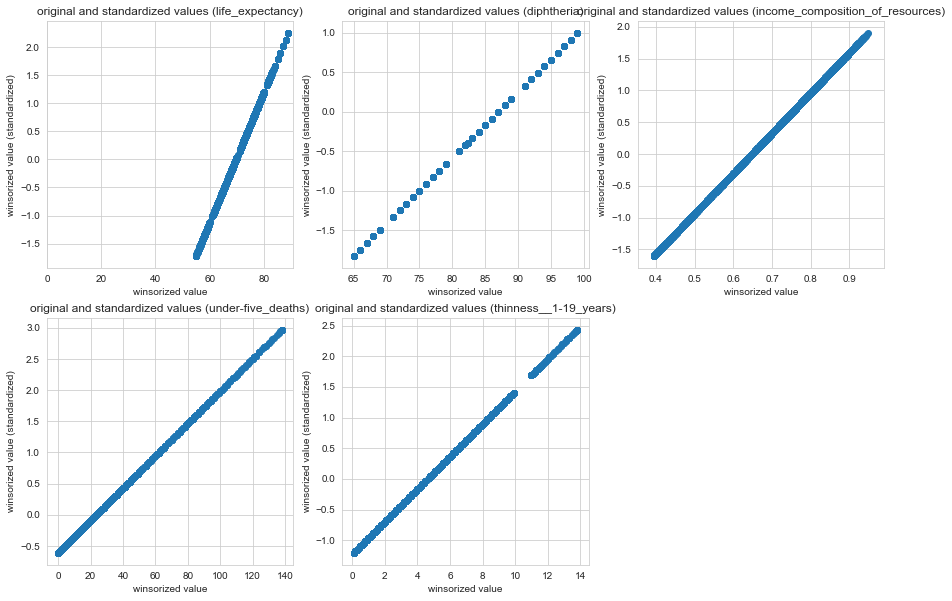

In [50]:
from sklearn.preprocessing import scale

features['life_expectancy_s'] = scale(features['life_expectancy'])
features['diphtheria_s'] = scale(features['diphtheria'])
features['income_composition_of_resources_s'] = scale(features['income_composition_of_resources'])
features['under-five_deaths_s'] = scale(features['under-five_deaths'])
features['thinness__1-19_years_s'] = scale(features['thinness__1-19_years'])
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(features['life_expectancy'], features['life_expectancy_s'])
plt.title('original and standardized values (life_expectancy)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')
plt.xlim(0.00000001)

plt.subplot(2,3,2)
plt.scatter(features['diphtheria'], features['diphtheria_s'])
plt.title('original and standardized values (diphtheria)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')

plt.subplot(2,3,3)
plt.scatter(features['income_composition_of_resources'], features['income_composition_of_resources_s'])
plt.title('original and standardized values (income_composition_of_resources)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')

plt.subplot(2,3,4)
plt.scatter(features['under-five_deaths'], features['under-five_deaths_s'])
plt.title('original and standardized values (under-five_deaths)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')

plt.subplot(2,3,5)
plt.scatter(features['thinness__1-19_years'], features['thinness__1-19_years_s'])
plt.title('original and standardized values (thinness__1-19_years)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')

plt.show()

### Summary

We started with 22 variables in our dataset including our target variable "life expectancy" and two categorical variables -- "country" and "status" ("Developing" vs. "Developed"). We <b>eliminated 10 of the variables due to data entry errors</b>, and worked with the rest variables to identify factors that increase and decrease life expectancy. 

After taking care of missing data and outliers, we looked at correlations and saw that the following factors increase life expectancy:
- "income composition of resources" and 
- immunization ("diphtheria").

The following factors decrease life expectancy:
- "under five deaths" rate and 
- "thinness 1-19 years". 

We suggested features for a model and gave examples of transforming, normalizing and standardizing data.